In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib

In [4]:
maindataframe = pd.read_csv("./Dataset/train.csv")
maindataframe.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,0,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,0,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,0,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,0,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,0,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [5]:
maindataframe.describe()

,sl_no,gender,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,0.353488,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,0.479168,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,0.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,0.000000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,0.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,1.000000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,1.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [6]:
maindataframe.isnull().sum()

sl_no              0
gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
status             0
salary            67
dtype: int64

In [7]:
maindataframe.drop('sl_no',axis=1,inplace=True)

In [8]:
categorical_col = ['ssc_b','hsc_b','hsc_s','degree_t','workex','specialisation']
encoder = OneHotEncoder(drop='first',sparse=False)
encoder_dataframe = pd.DataFrame(encoder.fit_transform(maindataframe[categorical_col]))
other_cols = [col for col in maindataframe.columns if col not in categorical_col ]
encoder_dataframe = pd.concat([encoder_dataframe,maindataframe[other_cols]],axis=1)
encoder_dataframe.head()
joblib.dump(encoder,'oneHotEncoder.pkl')

['oneHotEncoder.pkl']

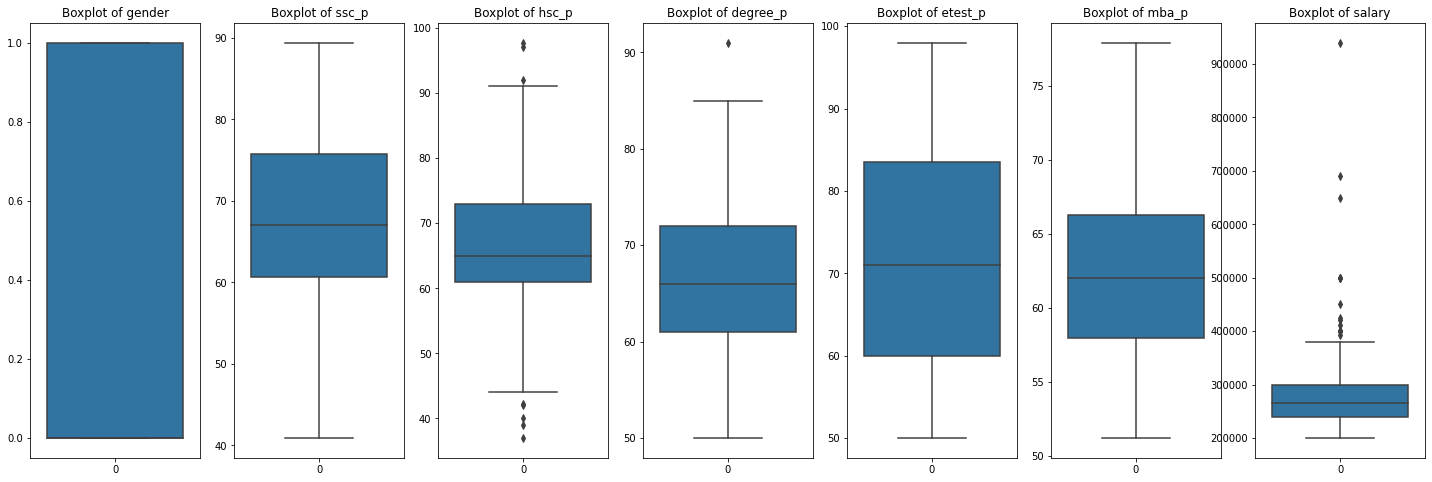

In [9]:
numerical_cols = [col for col in other_cols if col != "status"]
plt.figure(figsize=(25,8))
for col in numerical_cols:
    plt.subplot(1, len(numerical_cols), numerical_cols.index(col) + 1)
    sns.boxplot(data = encoder_dataframe[col])
    plt.title('Boxplot of {}'.format(col))
plt.show()

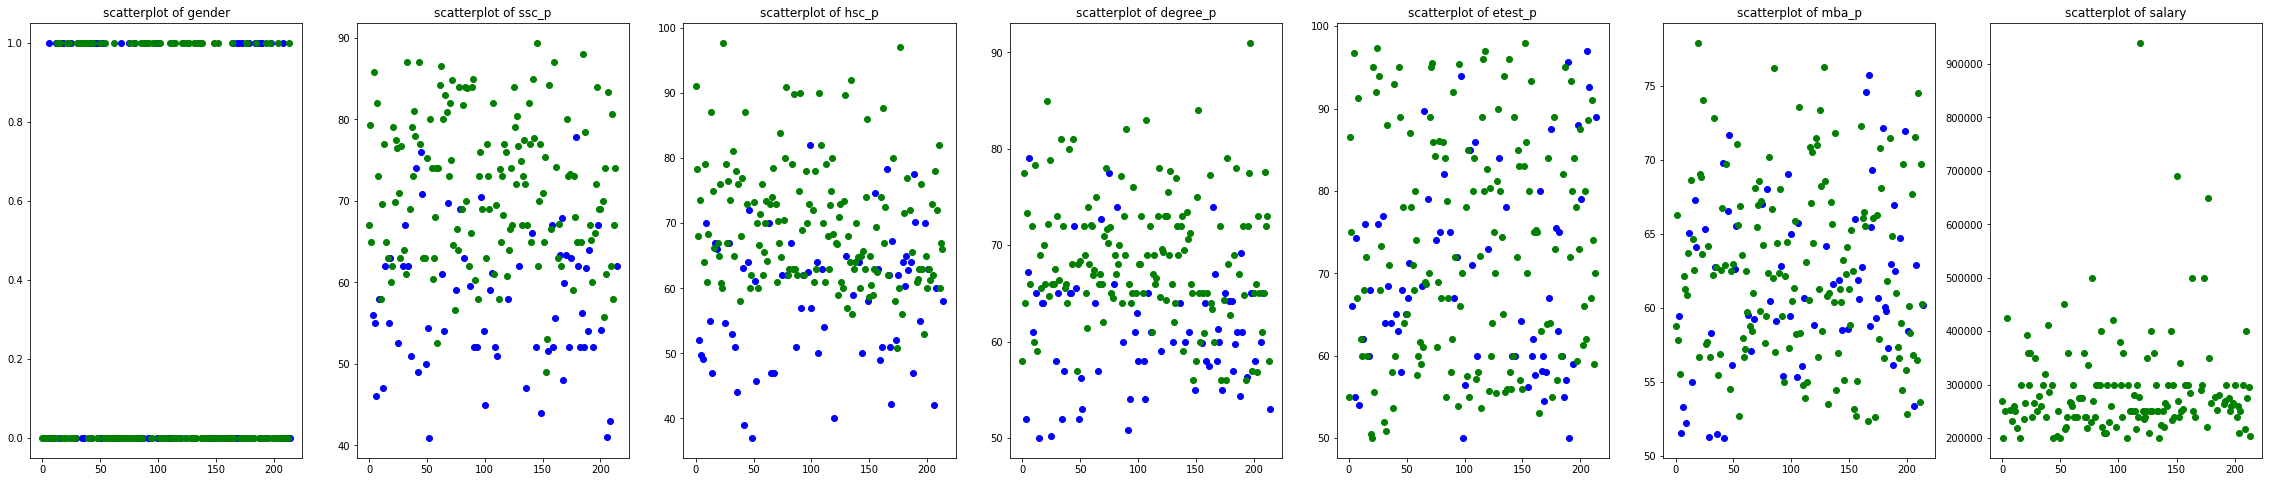

In [10]:
plt.figure(figsize=(40, 8))
for col in numerical_cols:
    mask = maindataframe['status'] == "Placed"    
    plt.subplot(1, len(numerical_cols), numerical_cols.index(col) + 1)
    plt.scatter(maindataframe.loc[~mask].index, maindataframe.loc[~mask, col], c='blue')    
    plt.scatter(maindataframe.loc[mask].index, maindataframe.loc[mask, col], c='green')    
    plt.title('scatterplot of {}'.format(col))
plt.show()


In [11]:
Q1 = np.percentile(encoder_dataframe['hsc_p'], 25)
Q3 = np.percentile(encoder_dataframe['hsc_p'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = encoder_dataframe[(encoder_dataframe["hsc_p"] < lower_bound) | (encoder_dataframe['hsc_p'] > upper_bound)]

# Remove outliers from the dataset
data_no_outliers = encoder_dataframe[~((encoder_dataframe['hsc_p'] < lower_bound) | (encoder_dataframe['hsc_p'] > upper_bound))]

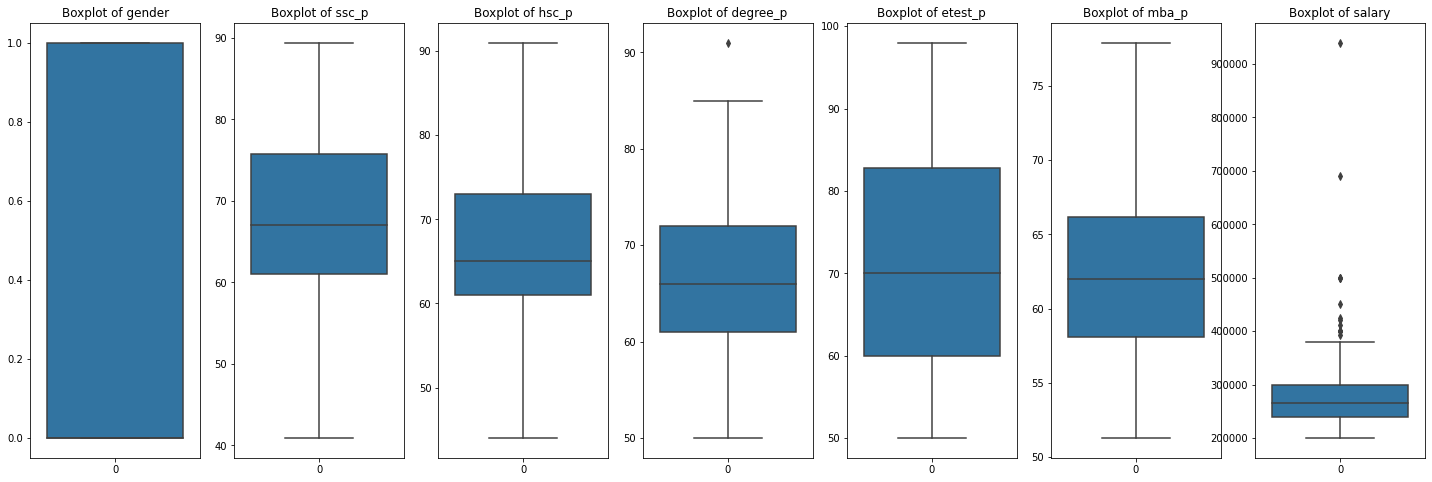

In [12]:
plt.figure(figsize=(25,8))
for col in numerical_cols:
    plt.subplot(1, len(numerical_cols), numerical_cols.index(col) + 1)
    sns.boxplot(data = data_no_outliers[col])
    plt.title('Boxplot of {}'.format(col))
plt.show()

In [13]:
status = data_no_outliers['status']
salary = data_no_outliers['salary']
data_no_outliers.drop(['status','salary'],axis=1, inplace=True)
print(status.head())
print(salary.head())
print(data_no_outliers.head())

0        Placed
1        Placed
2        Placed
3    Not Placed
4        Placed
Name: status, dtype: object
0    270000.0
1    200000.0
2    250000.0
3         NaN
4    425000.0
Name: salary, dtype: float64
     0    1    2    3    4    5    6    7  gender  ssc_p  hsc_p  degree_p  \
0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0       0  67.00  91.00     58.00   
1  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0       0  79.33  78.33     77.48   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0  65.00  68.00     64.00   
3  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0       0  56.00  52.00     52.00   
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0       0  85.80  73.60     73.30   

   etest_p  mba_p  
0     55.0  58.80  
1     86.5  66.28  
2     75.0  57.80  
3     66.0  59.43  
4     96.8  55.50  


C:\Users\resha\AppData\Local\Temp\ipykernel_15836\1423874104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers.drop(['status','salary'],axis=1, inplace=True)


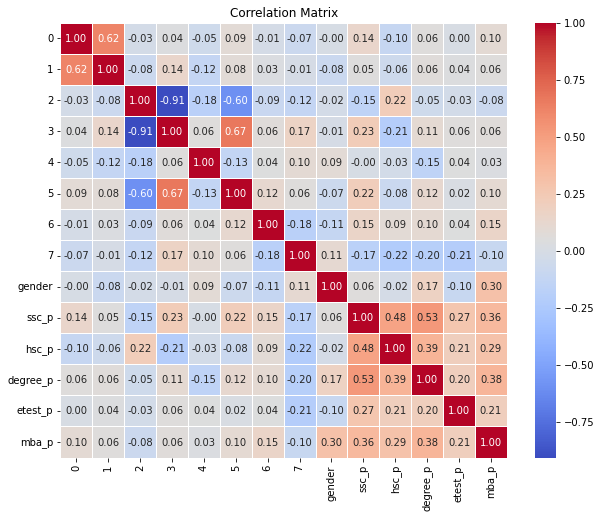

In [14]:
corr_matrix = data_no_outliers.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [15]:
label_encoder = LabelEncoder()
status = label_encoder.fit_transform(status)
joblib.dump(label_encoder,'labelencoder.pkl')
status

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0])

In [16]:
X_train_status, X_test_status, y_train_status, y_test_status = train_test_split(data_no_outliers, status , test_size=0.3, random_state=0)

In [17]:
X_train_status

,0,1,2,3,4,5,6,7,gender,ssc_p,hsc_p,degree_p,etest_p,mba_p
64,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,80.00,73.00,75.00,61.00,58.78
25,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,52.58,54.60,50.20,76.00,65.33
31,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1,67.00,53.00,65.00,64.00,58.32
63,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0,61.00,70.00,64.00,68.50,59.50
59,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,52.60,65.58,72.11,57.60,56.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,82.00,61.00,62.00,89.00,65.45
199,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0,69.00,65.00,57.00,73.00,55.80
121,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1,64.00,67.00,69.60,55.67,71.49
50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,75.20,73.20,68.40,65.00,62.98


In [18]:
scaler = StandardScaler()
X_train_status = scaler.fit_transform(X_train_status)
X_test_status = scaler.transform(X_test_status)
joblib.dump(scaler,'standardScaler.pkl')

c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


['standardScaler.pkl']

In [19]:
data_no_outliers.head()

,0,1,2,3,4,5,6,7,gender,ssc_p,hsc_p,degree_p,etest_p,mba_p
0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,67.00,91.00,58.00,55.0,58.80
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,79.33,78.33,77.48,86.5,66.28
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,65.00,68.00,64.00,75.0,57.80
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,56.00,52.00,52.00,66.0,59.43
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,85.80,73.60,73.30,96.8,55.50


In [20]:
logregmodel = LogisticRegression()
logregmodel.fit(X_train_status,y_train_status)
y_pred = logregmodel.predict(X_test_status)

In [21]:
rmse = np.sqrt(mean_squared_error(y_test_status, y_pred))
mae = mean_absolute_error(y_test_status, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print(classification_report(y_test_status,y_pred))

RMSE: 0.3984095364447979
MAE: 0.15873015873015872
              precision    recall  f1-score   support

           0       0.92      0.55      0.69        20
           1       0.82      0.98      0.89        43

    accuracy                           0.84        63
   macro avg       0.87      0.76      0.79        63
weighted avg       0.85      0.84      0.83        63



since recall for 0 is not that good we will try some other methods with logistic regression

1) Set decision threshold

In [22]:
predicted_probabilities_one = logregmodel.predict_proba(X_test_status)[:, 1]
predicted_probabilities_zero = logregmodel.predict_proba(X_test_status)[:,0]

In [23]:
for i in range(len(y_pred)):
    if y_pred[i]!=y_test_status[i]:
        print(y_pred[i]," , ",y_test_status[i]," , ",predicted_probabilities_one[i]," , ",predicted_probabilities_zero[i])

1  ,  0  ,  0.9535954853456103  ,  0.04640451465438966
1  ,  0  ,  0.9578288390349536  ,  0.04217116096504636
1  ,  0  ,  0.6012278845110195  ,  0.3987721154889805
1  ,  0  ,  0.509643833175251  ,  0.49035616682474903
1  ,  0  ,  0.8978987997099699  ,  0.10210120029003011
1  ,  0  ,  0.8501980711935084  ,  0.14980192880649157
0  ,  1  ,  0.14509021690154714  ,  0.8549097830984529
1  ,  0  ,  0.908297387823029  ,  0.09170261217697095
1  ,  0  ,  0.8733984867995055  ,  0.1266015132004945
1  ,  0  ,  0.9794314240209848  ,  0.02056857597901518


Here it can be seen that the problem is not with the decision threshold <br/>
at various instance the predicted probablity = 0.98 is wrong thus we will try something else

In [24]:
smote = SMOTE(random_state=20)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_status, y_train_status)

In [25]:
logregmodelresampled = LogisticRegression()
logregmodelresampled.fit(X_train_resampled,y_train_resampled)
y_pred = logregmodelresampled.predict(X_test_status)

In [26]:
rmse = np.sqrt(mean_squared_error(y_test_status, y_pred))
mae = mean_absolute_error(y_test_status, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print(classification_report(y_test_status,y_pred))

RMSE: 0.3563483225498992
MAE: 0.12698412698412698
              precision    recall  f1-score   support

           0       0.93      0.65      0.76        20
           1       0.86      0.98      0.91        43

    accuracy                           0.87        63
   macro avg       0.89      0.81      0.84        63
weighted avg       0.88      0.87      0.87        63



In [27]:
predicted_probabilities_one = logregmodelresampled.predict_proba(X_test_status)[:, 1]
predicted_probabilities_zero = logregmodelresampled.predict_proba(X_test_status)[:,0]
for i in range(len(y_pred)):
    if y_pred[i]!=y_test_status[i]:
        print(y_pred[i]," , ",y_test_status[i]," , ",predicted_probabilities_one[i]," , ",predicted_probabilities_zero[i])

1  ,  0  ,  0.9589004821044724  ,  0.04109951789552757
1  ,  0  ,  0.962385095154249  ,  0.03761490484575103
1  ,  0  ,  0.8533662716810434  ,  0.1466337283189566
1  ,  0  ,  0.7861450958445121  ,  0.2138549041554879
0  ,  1  ,  0.03472885420320879  ,  0.9652711457967912
1  ,  0  ,  0.9033958783837616  ,  0.09660412161623844
1  ,  0  ,  0.8286145727179065  ,  0.1713854272820935
1  ,  0  ,  0.9825273630722462  ,  0.017472636927753804


In [28]:
threshold = 0.6
y_pred_threshold = (predicted_probabilities_one >= threshold).astype(int)
report = classification_report(y_test_status, y_pred_threshold)
print(report)
joblib.dump(logregmodel,'logregmodel.pkl')

              precision    recall  f1-score   support

           0       0.87      0.65      0.74        20
           1       0.85      0.95      0.90        43

    accuracy                           0.86        63
   macro avg       0.86      0.80      0.82        63
weighted avg       0.86      0.86      0.85        63



['logregmodel.pkl']

As you can see we improved the recall for 0 using oversampling technique : SMOTE

Next lets test some other models for the same <br/>
we will start with SVM

In [29]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

In [30]:
svm.fit(X_train_status, y_train_status)
y_pred = svm.predict(X_test_status)

In [31]:
print(classification_report(y_test_status,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.50      0.65        20
           1       0.81      0.98      0.88        43

    accuracy                           0.83        63
   macro avg       0.86      0.74      0.76        63
weighted avg       0.84      0.83      0.81        63



while precision 1 is good but it does not generalize between cases with 0 and cases with 1 so we will go with logistic regression<br/>
next we will be predicting the salary using multiple linear regression

In [32]:
nan_indices = salary[salary.isna()].index
data_no_outliers = data_no_outliers.drop(nan_indices)
salary = salary.drop(nan_indices)

In [31]:
salary

0      270000.0
1      200000.0
2      250000.0
4      425000.0
7      252000.0
         ...   
209    216000.0
210    400000.0
211    275000.0
212    295000.0
213    204000.0
Name: salary, Length: 145, dtype: float64

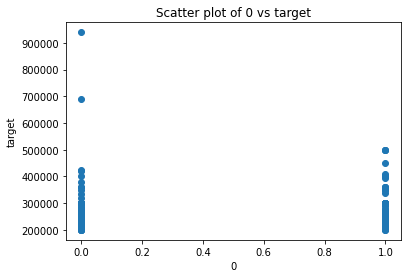

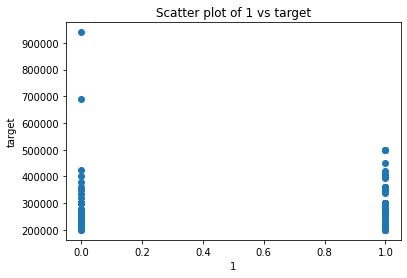

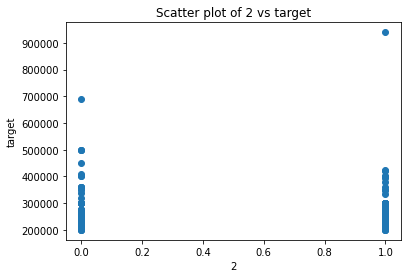

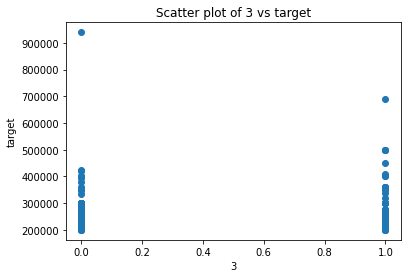

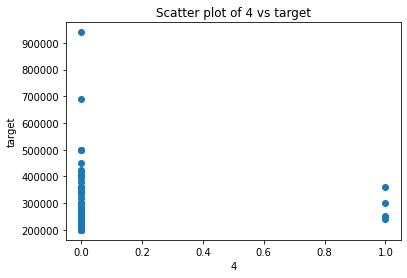

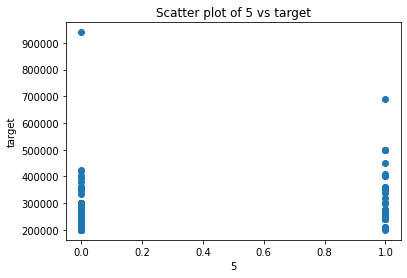

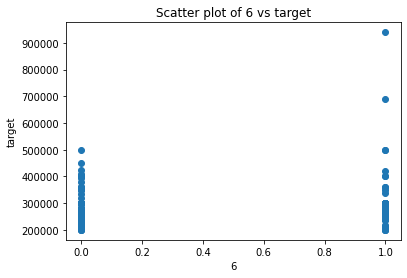

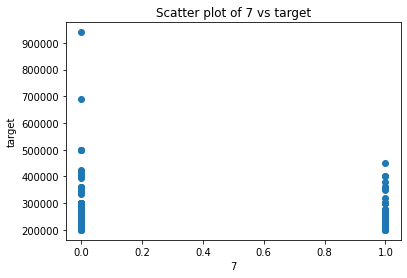

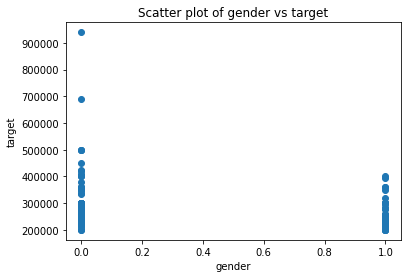

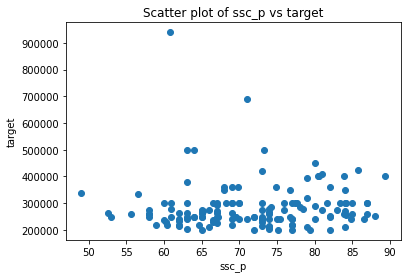

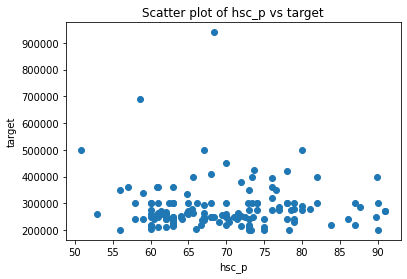

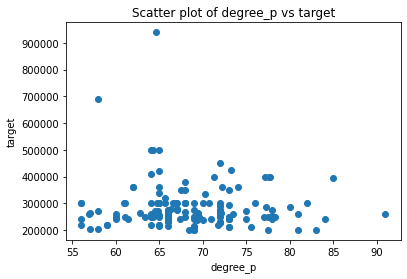

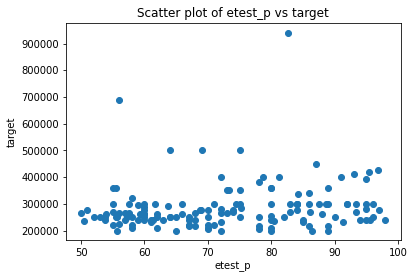

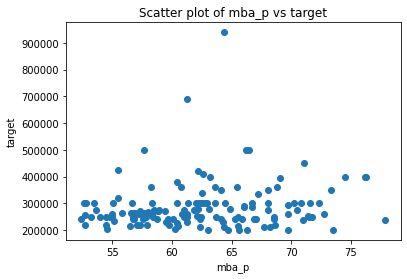

In [33]:
for col in data_no_outliers.columns:
    plt.scatter(data_no_outliers[col], salary)  # Replace 'target' with the actual target column name
    plt.xlabel(col)
    plt.ylabel('target')  # Replace 'target' with the actual target column name
    plt.title('Scatter plot of {} vs target'.format(col))
    plt.show()

In [34]:
data_no_outliers.head()

,0,1,2,3,4,5,6,7,gender,ssc_p,hsc_p,degree_p,etest_p,mba_p
0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,67.00,91.00,58.00,55.0,58.80
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,79.33,78.33,77.48,86.5,66.28
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,65.00,68.00,64.00,75.0,57.80
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,85.80,73.60,73.30,96.8,55.50
7,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,82.00,64.00,66.00,67.0,62.14


In [33]:
scaler = StandardScaler()
data_no_outliers = pd.DataFrame(scaler.fit_transform(data_no_outliers))

c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [35]:
X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(pd.DataFrame(data_no_outliers), pd.DataFrame(salary) , test_size=0.3, random_state=0)

In [36]:
lr = LinearRegression()
lr.fit(X_train_salary,y_train_salary)
y_pred = lr.predict(X_test_salary)

c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [37]:
mse = mean_squared_error(y_test_salary, y_pred)
r2 = r2_score(y_test_salary, y_pred)

print(mse)
print(r2)

4781749103.650935
0.12971645671817533


In [38]:
def forward_selection(X, y):
    n_features = X.shape[1]  # Number of features
    selected_features = []  # List to store selected features
    best_score = float('inf')  # Initialize best score as infinity
    
    # Loop through each feature
    for feature in X.columns:
        candidate_features = selected_features + [feature]  # Add a candidate feature
        
        # Create a new design matrix with the selected features
        X_train = X[candidate_features]
        
        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_train, y)
        
        # Predict the target variable
        y_pred = model.predict(X_train)
        
        # Calculate the mean squared error
        mse = mean_squared_error(y, y_pred)
        
        # Update the best score and selected features if the current model is better
        if mse < best_score:
            best_score = mse
            selected_features = candidate_features
    
    return selected_features, model


In [39]:
selected_features,lrfs = forward_selection(X_train_salary, y_train_salary)
print("Selected Features:", selected_features)
y_pred = lrfs.predict(X_test_salary[selected_features])
joblib.dump(scaler,'lrscaler.pkl')
joblib.dump(lrfs,'lrfs.pkl')

Selected Features: [0, 1, 2, 3, 4, 5, 6, 7, 'gender', 'ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']


c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got 

['lrfs.pkl']

In [40]:
mse = mean_squared_error(y_test_salary, y_pred)
r2 = r2_score(y_test_salary, y_pred)

print(mse)
print(r2)

4781749103.650935
0.12971645671817533


In [41]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_salary, y_train_salary)
y_pred = rf_model.predict(X_test_salary)

c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\resha\AppData\Local\Temp\ipykernel_15836\426507680.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_salary, y_train_salary)
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [55]:
mse = mean_squared_error(y_test_salary, y_pred)
r2 = r2_score(y_test_salary, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(lrfs.score(X_test_salary[selected_features],y_test_salary))

Mean Squared Error (MSE): 7621997806.818182
R-squared (R2) Score: -0.38721189975011505
0.129716456718176


In [56]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_salary,y_train_salary)
y_pred = ridge.predict(X_test_salary)

In [57]:
mse = mean_squared_error(y_test_salary, y_pred)
r2 = r2_score(y_test_salary, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print(ridge.score(X_test_salary,y_test_salary))

Mean Squared Error: 4729194443.15466
R^2 Score: 0.13928146215054948
0.13928146215054948
